In [4]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.spatial.distance import cdist
import yaml
import sys
import os
# Dynamically determine the project root directory
project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))
from src.data_loading.simple_loader import load_processed_berkeley_earth, load_processed_era5, load_config


class TemperatureDatasetMetrics:
    
    def __init__(self, variable='tavg'):
        """
        Initialize with a specific temperature variable.

        Variables: 'tavg', 'tmin', 'tmax'
        """
        self.variable = variable
        self.be_data = load_processed_berkeley_earth(variable)
        self.era5_data = load_processed_era5(variable)
        self.config = load_config()
        
    def calculate_basic_statistics(self, time_slice=('1940-01-01', '2025-01-01')):
        """Calculate basic statistical metrics."""
        be_temp = self.be_data.sel(time=slice(*time_slice)).temperature
        era5_temp = self.era5_data.sel(time=slice(*time_slice)).temperature
        
        # Remove NaN values for calculations
        valid_mask = ~(np.isnan(be_temp) | np.isnan(era5_temp))
        be_valid = be_temp.where(valid_mask)
        era5_valid = era5_temp.where(valid_mask)
        
        metrics = {
            'mean_difference': float((era5_valid - be_valid).mean().values),
            'std_difference': float((era5_valid - be_valid).std().values),
            'rmse': float(np.sqrt(((era5_valid - be_valid) ** 2).mean()).values),
            'mae': float(np.abs(era5_valid - be_valid).mean().values),
            'be_mean': float(be_valid.mean().values),
            'era5_mean': float(era5_valid.mean().values),
            'be_std': float(be_valid.std().values),
            'era5_std': float(era5_valid.std().values),
        }
        
        #Calculate correlation coefficient
        be_flat = be_valid.values.flatten()
        era5_flat = era5_valid.values.flatten()
        valid_indices = ~(np.isnan(be_flat) | np.isnan(era5_flat))
        
        if np.sum(valid_indices) > 0:
           correlation, p_value = stats.pearsonr(be_flat[valid_indices], era5_flat[valid_indices])
           metrics['correlation'] = float(correlation)
           metrics['correlation_pvalue'] = float(p_value)
        else:
           metrics['correlation'] = np.nan
           metrics['correlation_pvalue'] = np.nan
            
        return metrics
    
    def calculate_time_series(self, lat_slice=(-90, 90), land_only_flag=False):
        """Calculate spatially averaged metrics for given latitude band.
        Metrics include: mean difference, std_difference, rmse, and mae."""
        # slice latitude range
        be_temp = self.be_data.sel(latitude=slice(*lat_slice)).temperature
        era5_temp = self.era5_data.sel(latitude=slice(*lat_slice)).temperature
        
        # Remove NaN values for calculations
        valid_mask = ~(np.isnan(be_temp) | np.isnan(era5_temp))
        be_valid = be_temp.where(valid_mask)
        era5_valid = era5_temp.where(valid_mask)

        # If land_only_flag is True, apply land mask
        if land_only_flag:
            be_valid = be_valid.where(self.be_data.land_mask)
        
        # calculate spatially averaged mean difference
        difference = era5_valid - be_valid
        output = {}
        output['mean_difference'] = difference.mean(dim=['latitude', 'longitude'])
        output['std_difference'] = difference.std(dim=['latitude', 'longitude'])
        output['rmse'] = np.sqrt((difference ** 2).mean(dim=['latitude', 'longitude']))
        output['mae'] = np.abs(difference).mean(dim=['latitude', 'longitude'])
        return output

    def calculate_temporally_averaged_metrics(self, time_slice=('1940-01-01', '2025-01-01')):
        """Calculate temporally averaged metrics for the specified time slice."""
        # slice time range
        be_temp = self.be_data.sel(time=slice(*time_slice)).temperature
        era5_temp = self.era5_data.sel(time=slice(*time_slice)).temperature
        # Remove NaN values for calculations
        valid_mask = ~(np.isnan(be_temp) | np.isnan(era5_temp))
        be_valid = be_temp.where(valid_mask)
        era5_valid = era5_temp.where(valid_mask)
        difference = era5_valid - be_valid
        
        output = {}
        output['mean_difference'] = difference.mean(dim=['time'])
        output['std_difference'] = difference.std(dim=['time'])
        output['rmse'] = np.sqrt((difference ** 2).mean(dim=['time']))
        output['mae'] = np.abs(difference).mean(dim=['time'])
        return output

In [5]:
TAVG = TemperatureDatasetMetrics(variable='tavg')
TMAX = TemperatureDatasetMetrics(variable='tmax')
TMIN = TemperatureDatasetMetrics(variable='tmin')
# Define latitude slices and corresponding attribute names
latitude_slices = {
    "high_latn": (60, 90),
    "mid_latn": (30, 60),
    "low_latn": (0, 30),
    "high_lats": (-90, -60),
    "mid_lats": (-60, -30),
    "low_lats": (-30, 0),
}
# Loop through the latitude slices and calculate metrics
for attr, lat_slice in latitude_slices.items():
    setattr(TAVG, attr, TAVG.calculate_time_series(lat_slice=lat_slice), land_only_flag=True)
    setattr(TMAX, attr, TMAX.calculate_time_series(lat_slice=lat_slice), land_only_flag=True)
    setattr(TMIN, attr, TMIN.calculate_time_series(lat_slice=lat_slice), land_only_flag=False)

/home/devin/miniconda3/envs/temp-comparison/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


TypeError: setattr() takes no keyword arguments

In [14]:
decade = ('2015-01-01', '2025-01-01')
TAVG.temporal_metrics = TAVG.calculate_temporally_averaged_metrics(time_slice = decade)
TMAX.temporal_metrics = TMAX.calculate_temporally_averaged_metrics(time_slice = decade)
TMIN.temporal_metrics = TMIN.calculate_temporally_averaged_metrics(time_slice = decade)

/home/devin/miniconda3/envs/temp-comparison/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/devin/miniconda3/envs/temp-comparison/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/devin/miniconda3/envs/temp-comparison/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


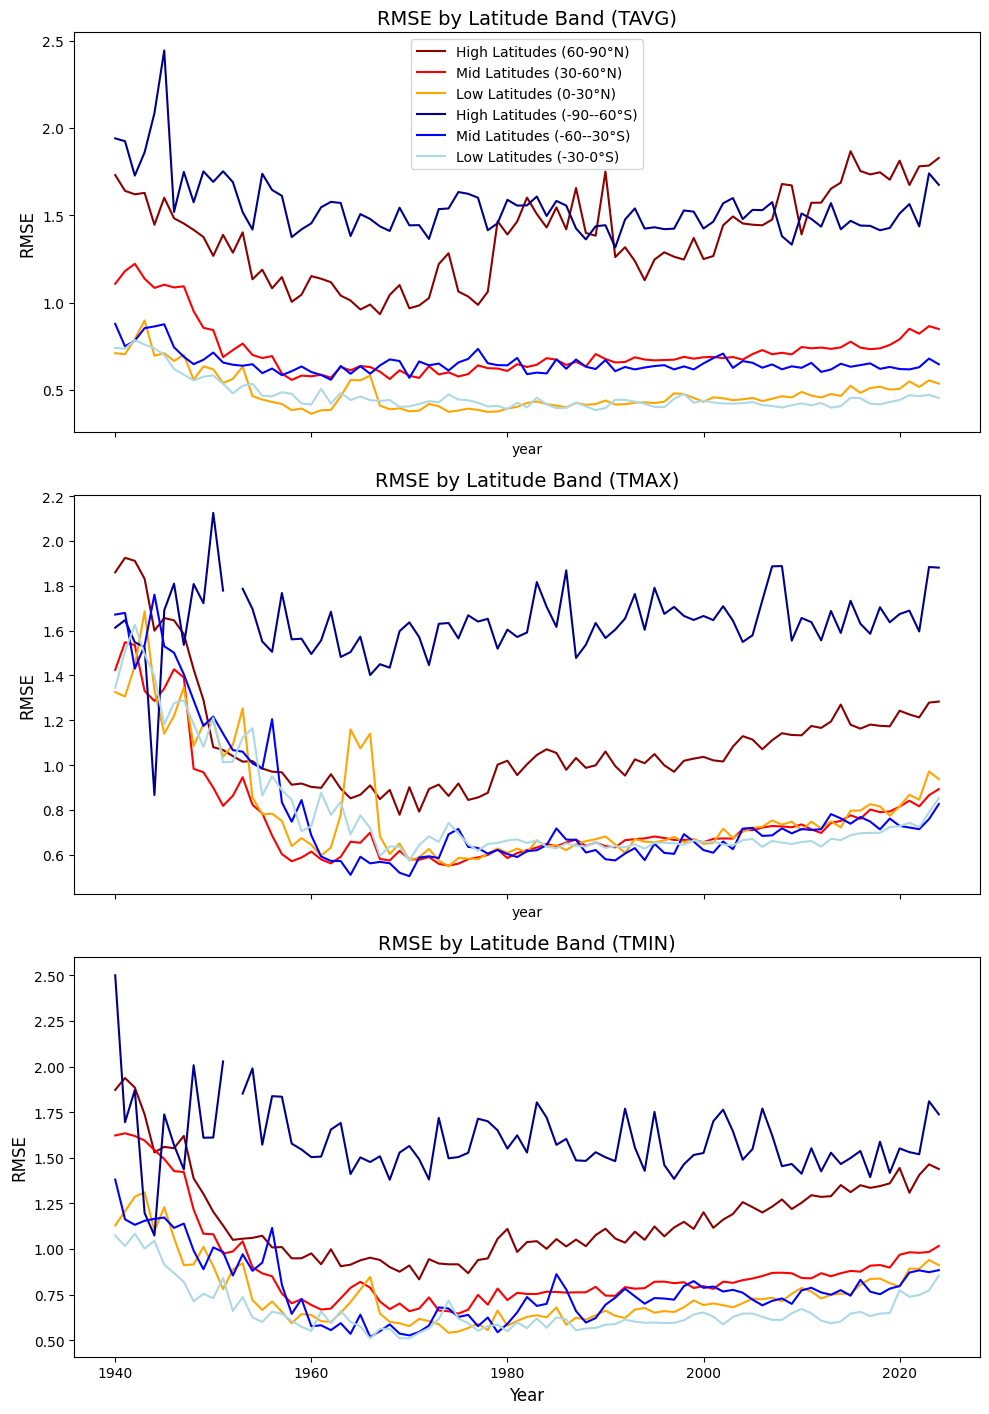

In [119]:
# Define the latitude bands and their corresponding labels and colors
latitude_bands = {
    "high_latn": ("High Latitudes (60-90°N)", "darkred"),
    "mid_latn": ("Mid Latitudes (30-60°N)", "red"),
    "low_latn": ("Low Latitudes (0-30°N)", "orange"),
    "high_lats": ("High Latitudes (-90--60°S)", "darkblue"),
    "mid_lats": ("Mid Latitudes (-60--30°S)", "blue"),
    "low_lats": ("Low Latitudes (-30-0°S)", "lightblue"),
}

metric = 'rmse'

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot for TAVG
for band, (label, color) in latitude_bands.items():
    getattr(TAVG, band)[metric].groupby('time.year').mean().plot(ax=axes[0], label=label, color=color)
axes[0].set_ylabel(f"{metric.upper()}", fontsize=12)
axes[0].set_title(f"{metric.upper()} by Latitude Band (TAVG)", fontsize=14)
axes[0].legend()

# Plot for TMAX

for band, (label, color) in latitude_bands.items():
    getattr(TMAX, band)[metric].groupby('time.year').mean().plot(ax=axes[1], label=label, color=color)
axes[1].set_ylabel(f"{metric.upper()}", fontsize=12)
axes[1].set_title(f"{metric.upper()} by Latitude Band (TMAX)", fontsize=14)
#axes[1].legend()

# Plot for TMIN

for band, (label, color) in latitude_bands.items():
    getattr(TMIN, band)[metric].groupby('time.year').mean().plot(ax=axes[2], label=label, color=color)
axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel(f"{metric.upper()}", fontsize=12)
axes[2].set_title(f"{metric.upper()} by Latitude Band (TMIN)", fontsize=14)
#axes[2].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent clipping
plt.show()

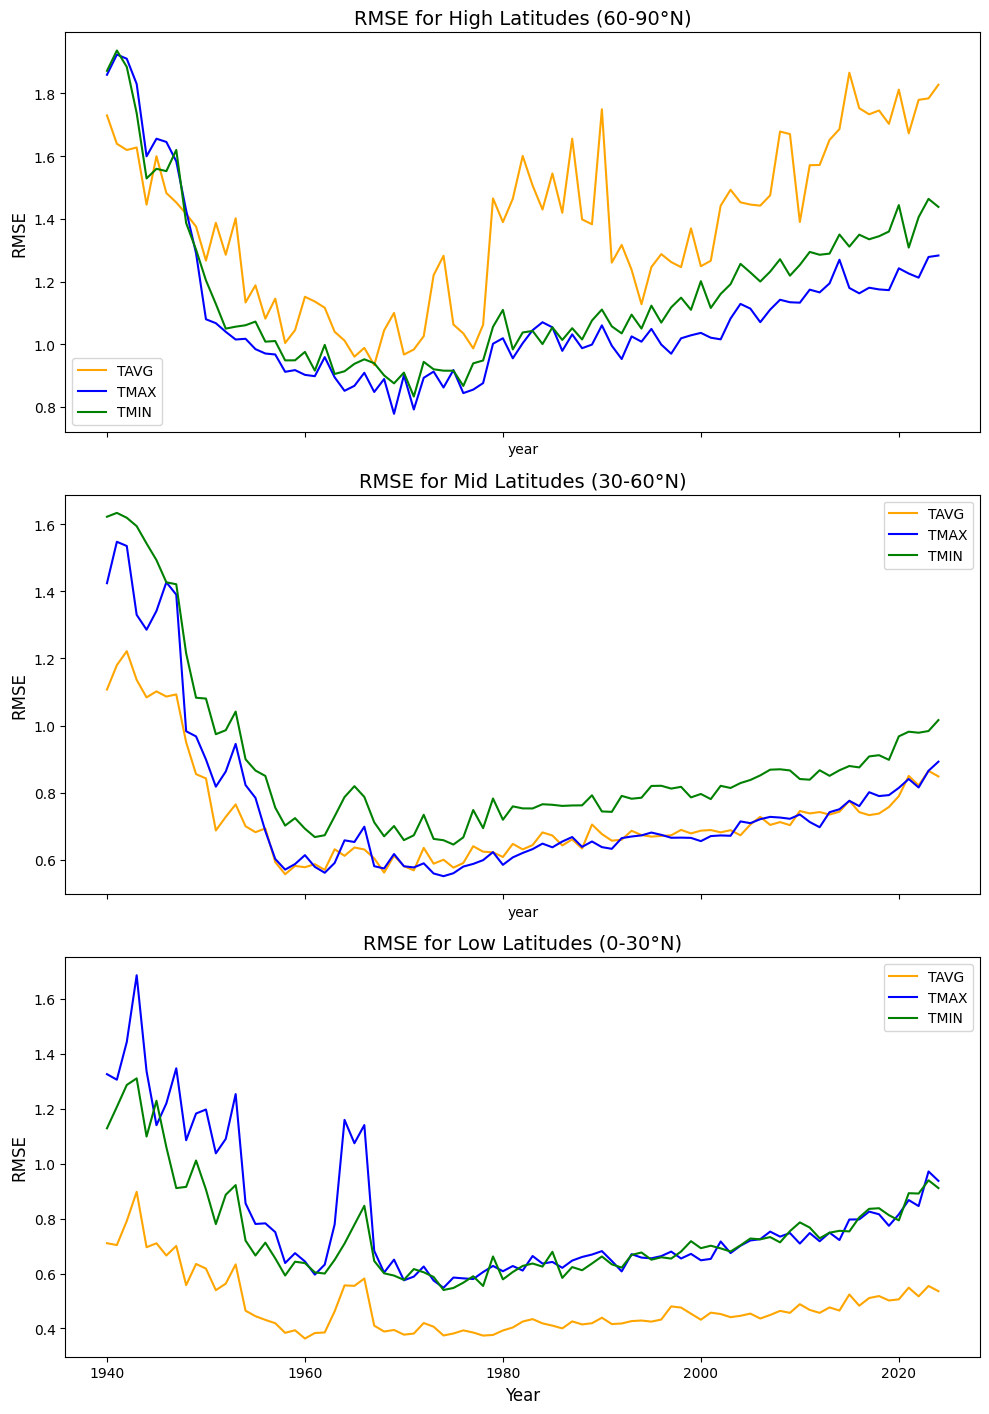

In [114]:
# Define the latitude bands and their corresponding labels and colors
latitude_bands = {
    "high_latn": ("High Latitudes (60-90°N)", "darkred"),
    "mid_latn": ("Mid Latitudes (30-60°N)", "red"),
}

metric = 'rmse'

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot for High Latitudes (60-90°N)

getattr(TAVG, "high_latn")[metric].groupby('time.year').mean().plot(ax=axes[0], label="TAVG", color="orange")
getattr(TMAX, "high_latn")[metric].groupby('time.year').mean().plot(ax=axes[0], label="TMAX", color="blue")
getattr(TMIN, "high_latn")[metric].groupby('time.year').mean().plot(ax=axes[0], label="TMIN", color="green")
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title("RMSE for High Latitudes (60-90°N)", fontsize=14)
axes[0].legend()

# Plot for Mid Latitudes (30-60°N)

getattr(TAVG, "mid_latn")[metric].groupby('time.year').mean().plot(ax=axes[1], label="TAVG", color="orange")
getattr(TMAX, "mid_latn")[metric].groupby('time.year').mean().plot(ax=axes[1], label="TMAX", color="blue")
getattr(TMIN, "mid_latn")[metric].groupby('time.year').mean().plot(ax=axes[1], label="TMIN", color="green")
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title("RMSE for Mid Latitudes (30-60°N)", fontsize=14)
axes[1].legend()

# Plot for Low Latitudes (0-30°N)

getattr(TAVG, "low_latn")[metric].groupby('time.year').mean().plot(ax=axes[2], label="TAVG", color="orange")
getattr(TMAX, "low_latn")[metric].groupby('time.year').mean().plot(ax=axes[2], label="TMAX", color="blue")
getattr(TMIN, "low_latn")[metric].groupby('time.year').mean().plot(ax=axes[2], label="TMIN", color="green")
axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('RMSE', fontsize=12)
axes[2].set_title("RMSE for Low Latitudes (0-30°N)", fontsize=14)
axes[2].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent clipping
plt.show()


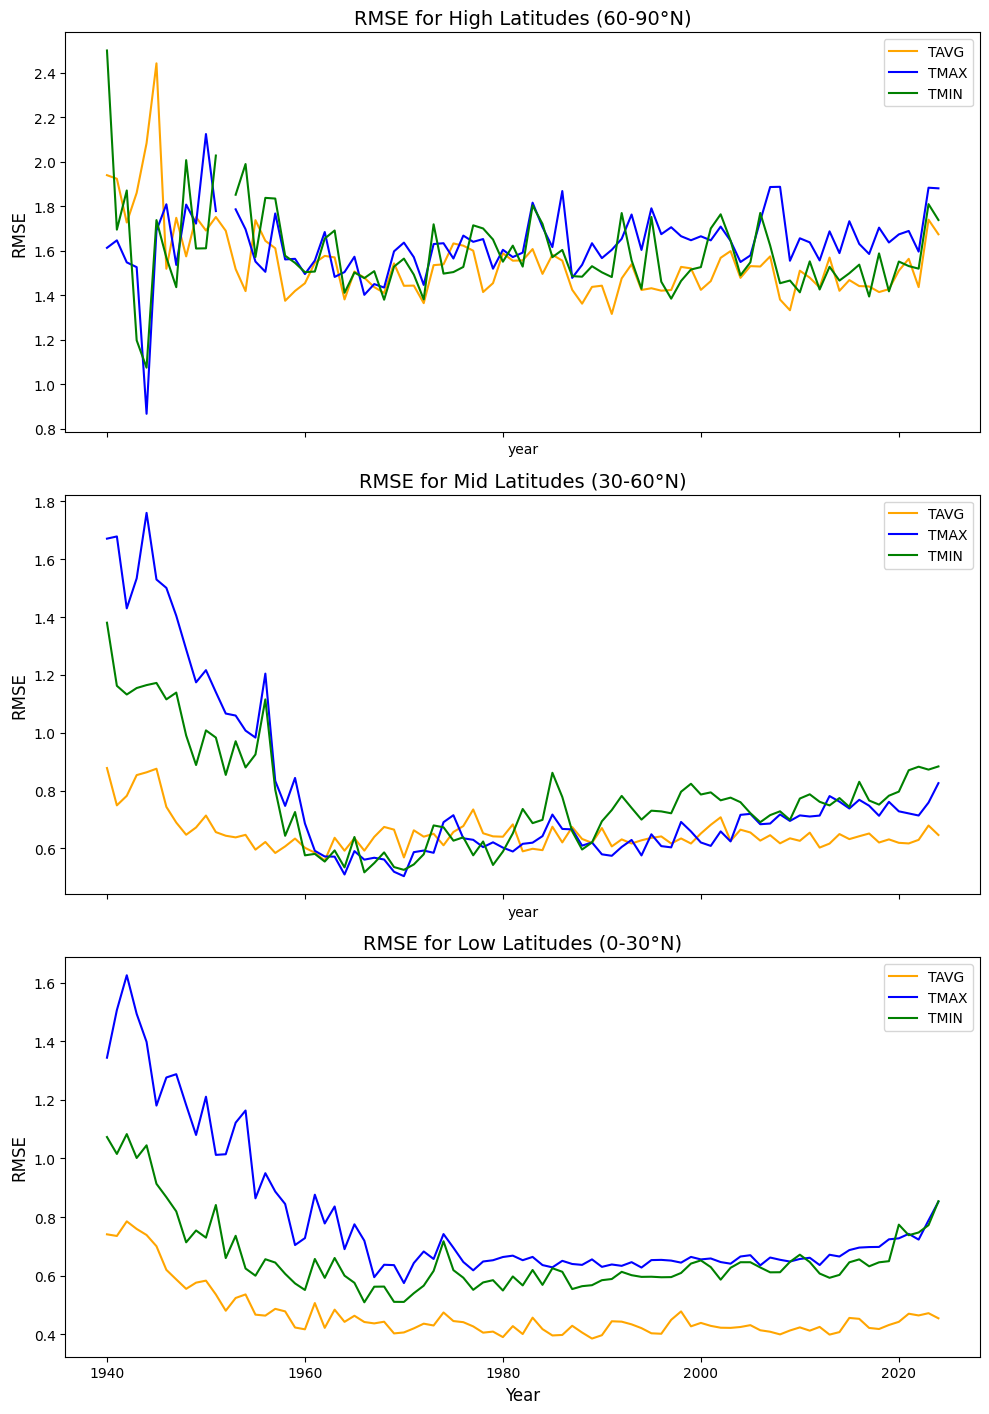

In [115]:
# Define the latitude bands and their corresponding labels and colors
#latitude_bands = {
#    "high_latn": ("High Latitudes (60-90°N)", "darkred"),
#    "mid_latn": ("Mid Latitudes (30-60°N)", "red"),
#}

metric = 'rmse'

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot for High Latitudes (60-90°N)

getattr(TAVG, "high_lats")[metric].groupby('time.year').mean().plot(ax=axes[0], label="TAVG", color="orange")
getattr(TMAX, "high_lats")[metric].groupby('time.year').mean().plot(ax=axes[0], label="TMAX", color="blue")
getattr(TMIN, "high_lats")[metric].groupby('time.year').mean().plot(ax=axes[0], label="TMIN", color="green")
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title("RMSE for High Latitudes (60-90°N)", fontsize=14)
axes[0].legend()

# Plot for Mid Latitudes (30-60°N)

getattr(TAVG, "mid_lats")[metric].groupby('time.year').mean().plot(ax=axes[1], label="TAVG", color="orange")
getattr(TMAX, "mid_lats")[metric].groupby('time.year').mean().plot(ax=axes[1], label="TMAX", color="blue")
getattr(TMIN, "mid_lats")[metric].groupby('time.year').mean().plot(ax=axes[1], label="TMIN", color="green")
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title("RMSE for Mid Latitudes (30-60°N)", fontsize=14)
axes[1].legend()

# Plot for Low Latitudes (0-30°N)

getattr(TAVG, "low_lats")[metric].groupby('time.year').mean().plot(ax=axes[2], label="TAVG", color="orange")
getattr(TMAX, "low_lats")[metric].groupby('time.year').mean().plot(ax=axes[2], label="TMAX", color="blue")
getattr(TMIN, "low_lats")[metric].groupby('time.year').mean().plot(ax=axes[2], label="TMIN", color="green")
axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('RMSE', fontsize=12)
axes[2].set_title("RMSE for Low Latitudes (0-30°N)", fontsize=14)
axes[2].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent clipping
plt.show()

Text(0.5, 1.0, 'RMSE for TMAX (2015-2025)')

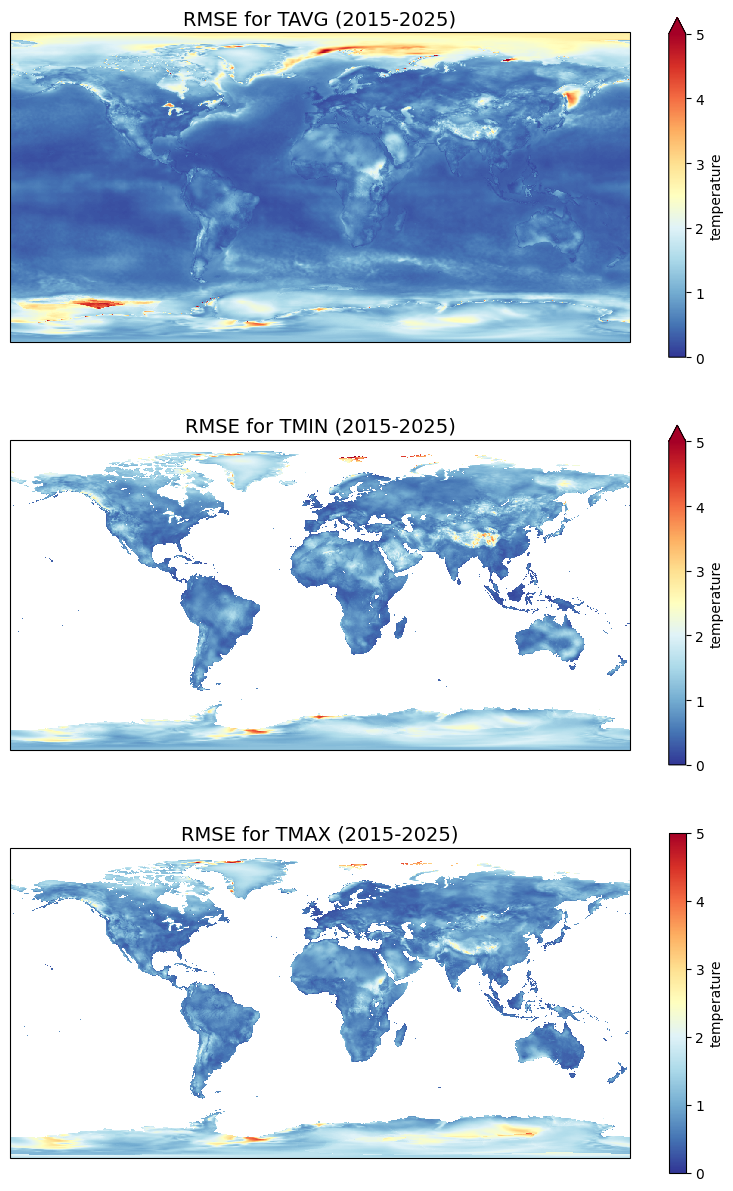

In [17]:
# create RMSE maps averaged across the last decade
vmin = 0
vmax = 5
fig, axes = plt.subplots(3, 1, figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})
TAVG.temporal_metrics['rmse'].plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
axes[0].set_title("RMSE for TAVG (2015-2025)", fontsize=14)
TMIN.temporal_metrics['rmse'].plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
axes[1].set_title("RMSE for TMIN (2015-2025)", fontsize=14)
TMAX.temporal_metrics['rmse'].plot(ax=axes[2], vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
axes[2].set_title("RMSE for TMAX (2015-2025)", fontsize=14)




In [ ]:
# plot absolute differences (not anomalies)
# plot anomaly differenes for each month
# station data saved in /main/Berkeley_Earth
# Occurence table indicates whether there was a measurement for a given time 
# has dimensions # stations x time
# Metric robert is providing returns a number from zero to one that indicates whether
# the variance of the station data is close to or exceeds the variance from the krigging. 
# If the variances are similar or station variance is higher than we get a 1 if it is lower than we
# get a 0

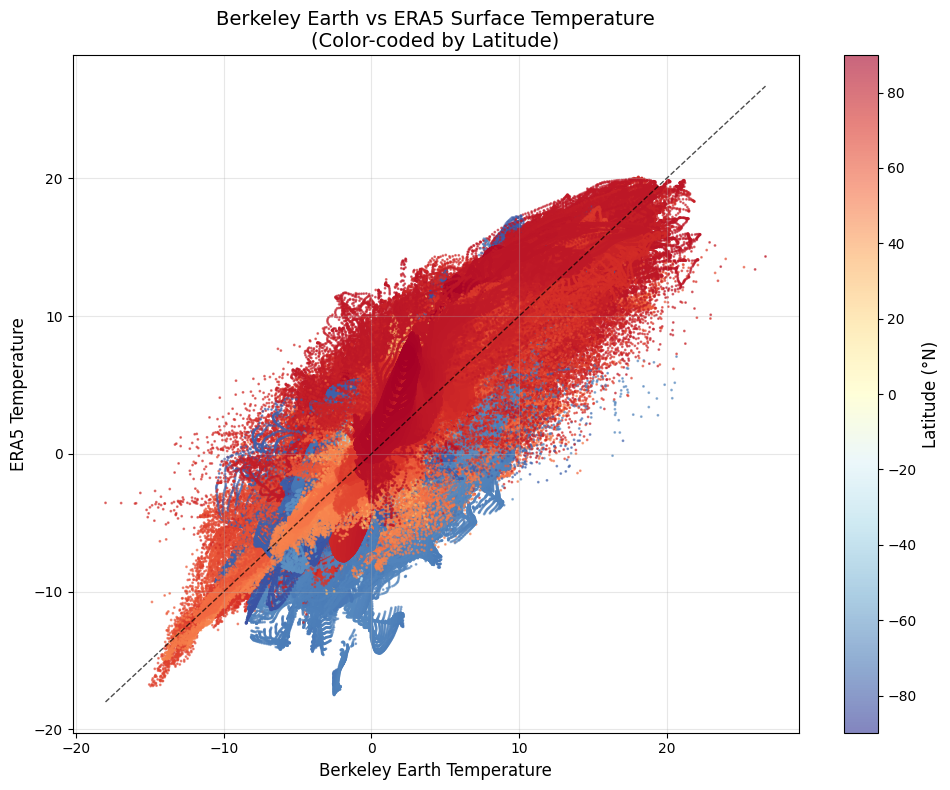

Number of data points: 136,248,991
Temperature range: -18.01 to 26.69
Latitude range: -89.88° to 89.88°
Correlation coefficient: 0.8498


In [17]:
# Flatten the data to 1D arrays for scatter plotting
berkeley_flat = be_temp.values.flatten()
era5_flat = era5_temp.values.flatten()

# Create latitude array that matches the flattened temperature data
# We need to broadcast latitude to match the shape of temperature data
lat_coords = metrics.be_data.latitude.values  # or era5_temp.lat.values (should be the same)

# Create a meshgrid to broadcast latitude across all time and longitude dimensions
lat_broadcasted = np.broadcast_to(
    lat_coords[np.newaxis, :, np.newaxis], 
    be_temp.shape
)
lat_flat = lat_broadcasted.flatten()

# Remove any NaN values (if present)
mask = ~(np.isnan(berkeley_flat) | np.isnan(era5_flat))
berkeley_clean = berkeley_flat[mask]
era5_clean = era5_flat[mask]
lat_clean = lat_flat[mask]

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(berkeley_clean, era5_clean, c=lat_clean, 
                     cmap='RdYlBu_r', alpha=0.6, s=1)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Latitude (°N)', fontsize=12)

# Add labels and title
plt.xlabel('Berkeley Earth Temperature', fontsize=12)
plt.ylabel('ERA5 Temperature', fontsize=12)
plt.title('Berkeley Earth vs ERA5 Surface Temperature\n(Color-coded by Latitude)', fontsize=14)

# Add 1:1 line for reference
min_temp = min(berkeley_clean.min(), era5_clean.min())
max_temp = max(berkeley_clean.max(), era5_clean.max())
plt.plot([min_temp, max_temp], [min_temp, max_temp], 'k--', alpha=0.7, linewidth=1)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Make layout tight
plt.tight_layout()
plt.show()

# Optional: Calculate correlation coefficient
correlation = np.corrcoef(berkeley_clean, era5_clean)[0, 1]
print(f"Correlation coefficient: {correlation:.4f}")